# Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='whitegrid')

import category_encoders as ce
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor 
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.svm import LinearSVR

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor

# Goal

Goal: Predict the views of YouTube Shorts using the given data about each sample.

# Inputting the data

Source of the dataset: https://www.kaggle.com/datasets/prince7489/youtube-shorts-performance-dataset

In [2]:
raw_df = pd.read_csv('youtube_shorts_performance_dataset.csv')

In [3]:
df = raw_df.copy()

In [4]:
df.head(3)

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food


# Exploratory Data Analysis (EDA)

## General Exploration

In [5]:
df.head(5)

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        300 non-null    object
 1   title           300 non-null    object
 2   duration_sec    300 non-null    int64 
 3   hashtags_count  300 non-null    int64 
 4   views           300 non-null    int64 
 5   likes           300 non-null    int64 
 6   comments        300 non-null    int64 
 7   shares          300 non-null    int64 
 8   upload_hour     300 non-null    int64 
 9   category        300 non-null    object
dtypes: int64(7), object(3)
memory usage: 23.6+ KB


In [7]:
df.describe()

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,31.730000,4.343333,245058.166667,23063.126667,2638.296667,999.576667,11.543333
std,16.042912,2.956562,141338.982093,14597.458220,1416.827287,564.410105,6.814414
min,5.000000,0.000000,1404.000000,109.000000,40.000000,2.000000,0.000000
25%,18.000000,2.000000,129620.500000,10342.000000,1445.750000,516.250000,6.000000
50%,32.000000,4.000000,255962.000000,21779.500000,2863.500000,988.000000,12.000000
75%,45.000000,7.000000,356805.000000,36706.500000,3761.000000,1463.750000,17.000000
max,59.000000,9.000000,499401.000000,49923.000000,4971.000000,1998.000000,23.000000


In [8]:
df['category'].value_counts()

category
Food         57
Tech         55
Comedy       53
Education    53
Lifestyle    42
Travel       40
Name: count, dtype: int64

In [9]:
len(df) - len(df.drop_duplicates())

0

Conclusions:

Positives:\
All columns have the correct data type.\
There are no missing data, wrong values or duplicates (no need for data cleaning).\
6 categories, occurences are similar (all are ranging from 40 to 57).

Negatives:\
Dataset is quite small and dimensionality is medium-sized; 300 rows and 10 columns, making it more difficult to predict patterns.\
Standard deviation is very high in most numerical columns, which is normal for a dataset this size but is a sign that there may be a lot of outliers.

## Data Visualizations

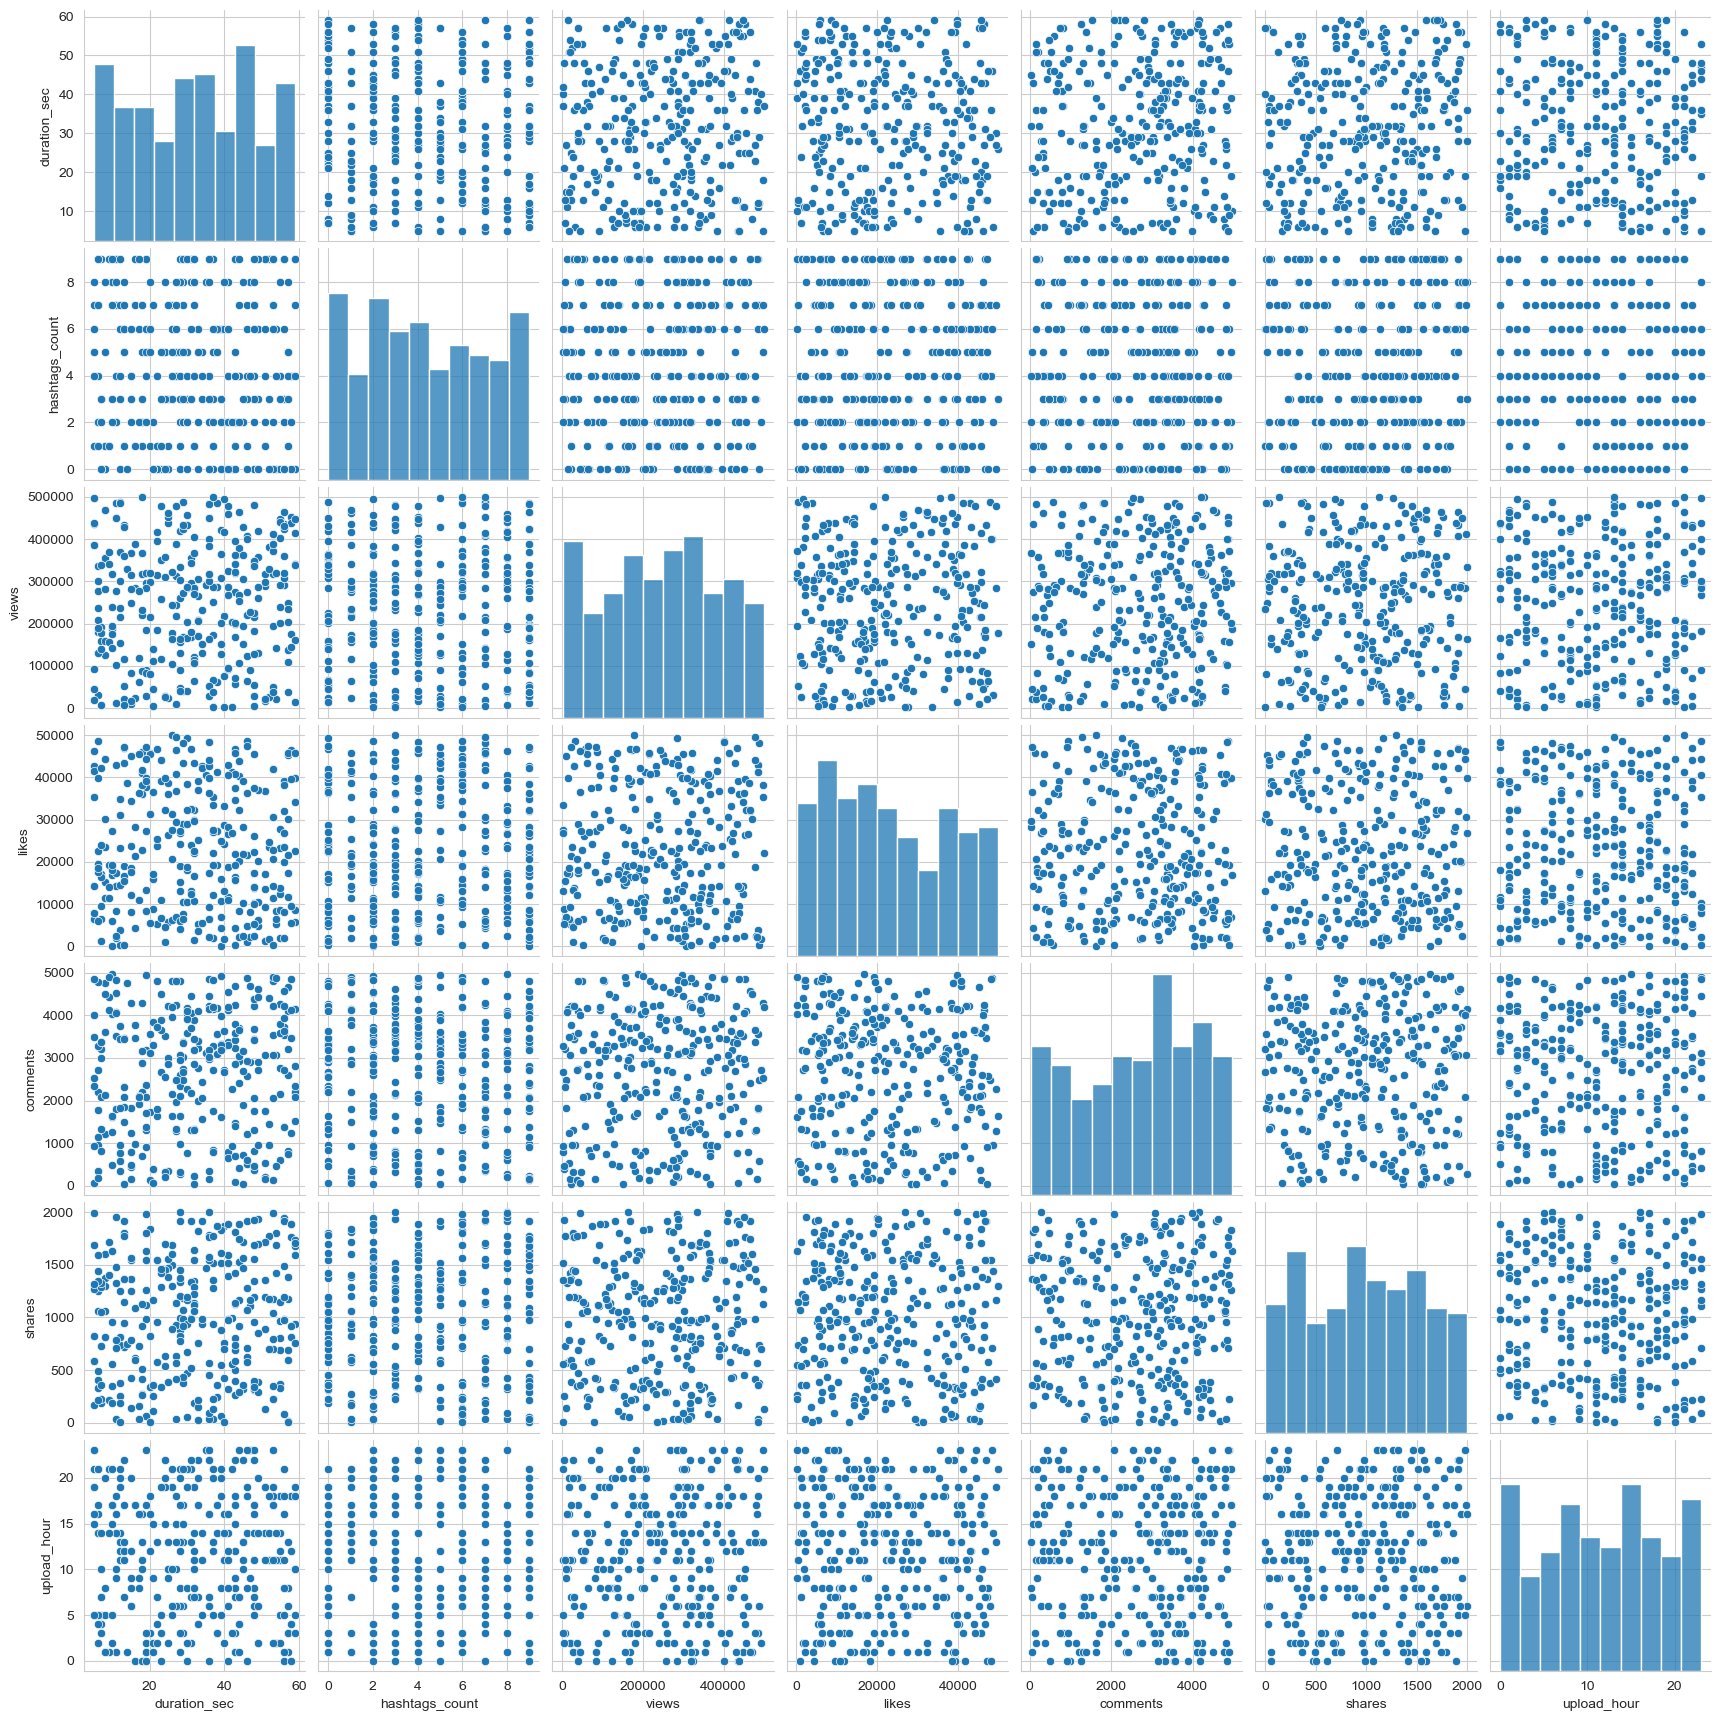

In [10]:
sns.pairplot(df)

<Axes: >

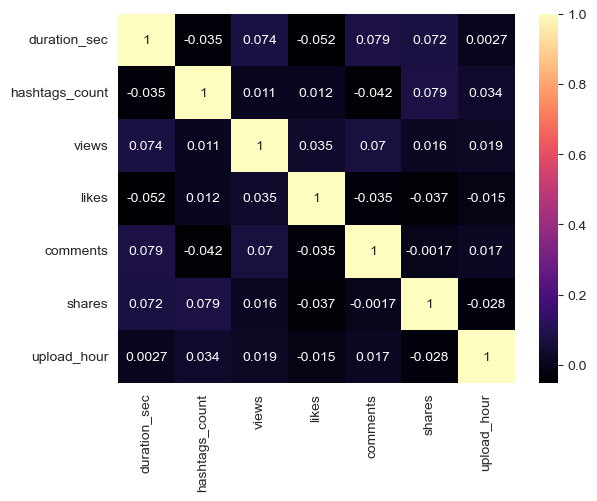

In [11]:
df_correlations = df.corr(numeric_only=True)
sns.heatmap(df_correlations,annot=True,cmap='magma')

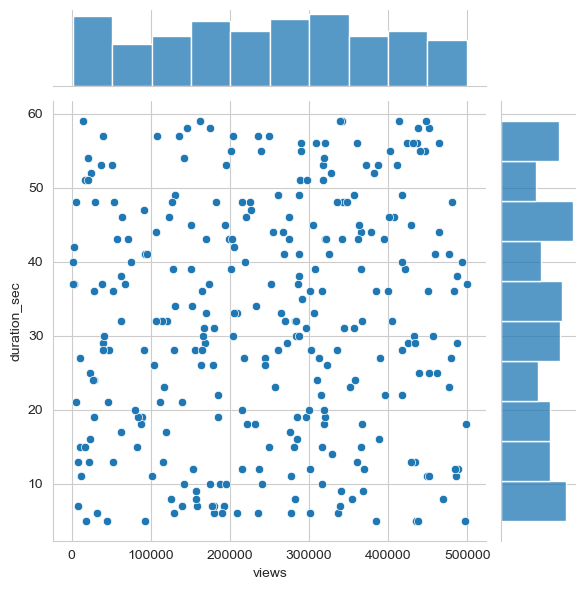

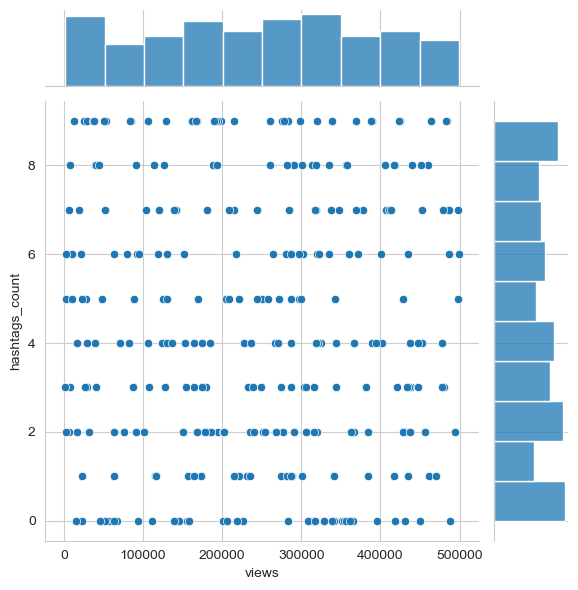

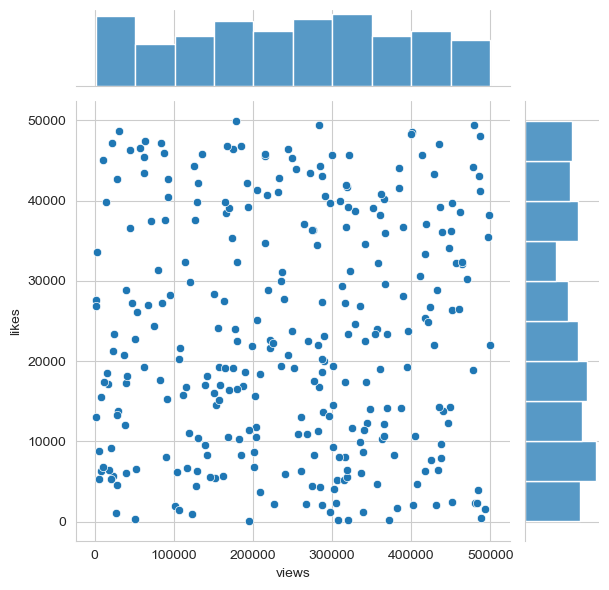

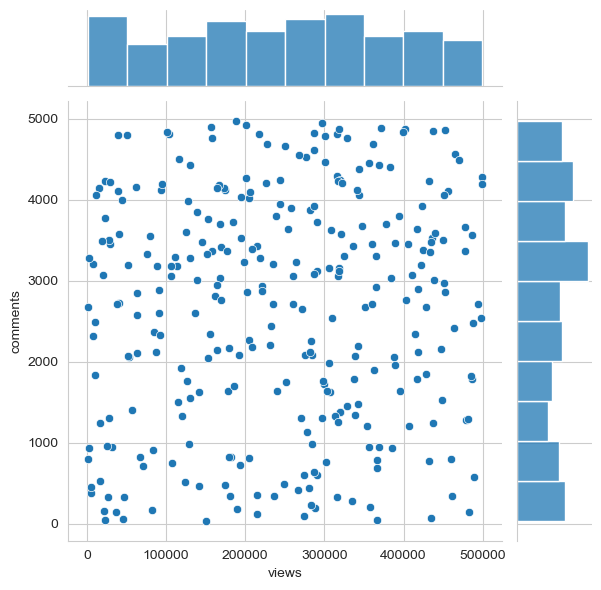

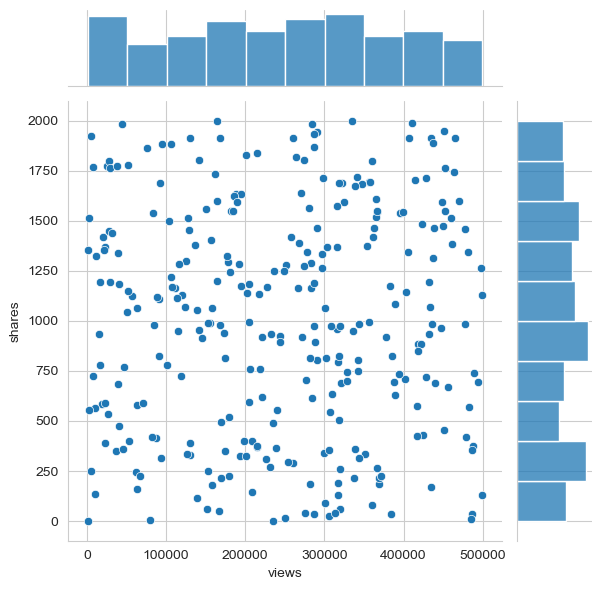

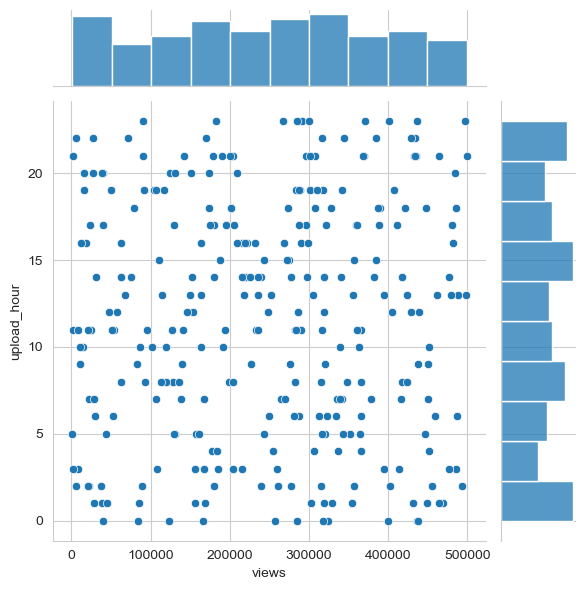

In [12]:
for i,col in enumerate(df.drop(['video_id','title','category','views'],axis=1).columns):
    sns.jointplot(df,x='views',y=col)

No clear patterns between views and other columns

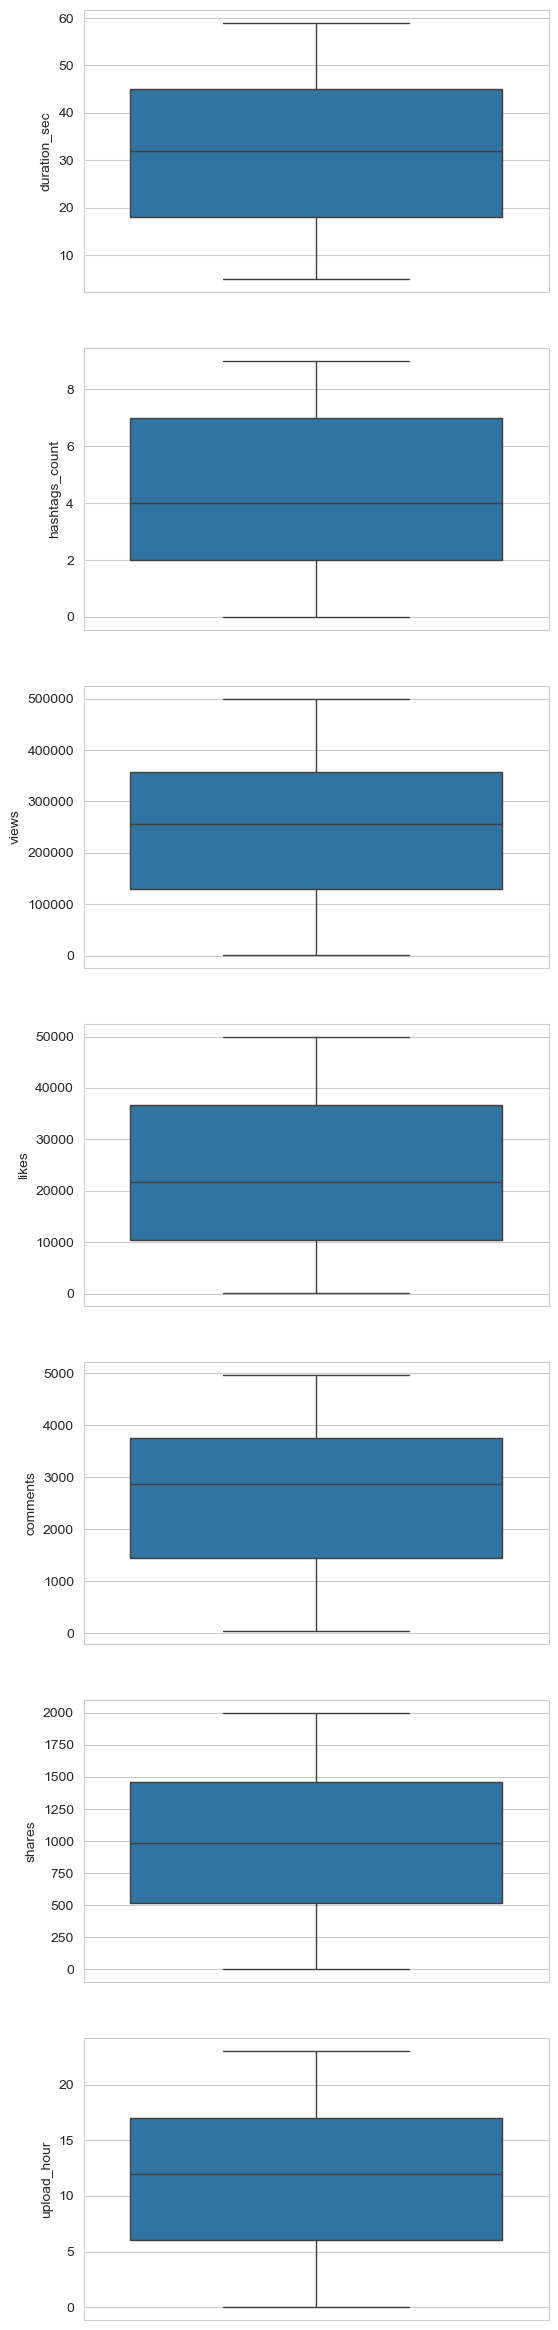

In [13]:
fig, axes = plt.subplots(7,1,figsize=(6,30))
for i,col in enumerate(df_correlations.columns):
    sns.boxplot(df, y=col,ax=axes[i])

There seems to be no outliers visible in the box plot, even though std was very high for most columns, which is strange.\
Let's confirm there are no outliers:

In [14]:
df_numeric = df.select_dtypes(include='number')

In [15]:
Q1 = df_numeric.quantile(0.25)
Q2 = df_numeric.quantile(0.5)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
high_limit = Q3 + 1.5 * IQR
low_limit = Q1 - 1.5 * IQR
n_outliers = ((df_numeric < low_limit) | (df_numeric > high_limit)).sum().sum()
n_outliers

np.int64(0)

There are no outliers.

# First Approach (manual)

!!!\
ATTENTION\
Please Note that this approach is purely made for experimental and learning purposes. The second approach is better, cleaner to read, and is what would normally happen in a real-world project. Feel free to skip this approach entirely.\
!!!

\
\
Copying the original dataframe to perform the first approach:

In [16]:
df1 = df.copy()

## Data Preprocessing

In [17]:
df1.head(5)

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech


Dropping useless columns: "video_id" and "title":

In [18]:
df1.drop(['video_id','title'],axis=1,inplace=True)

Copying the df1 dataset to preprocess two copies differently:\
df1_tree is for tree models.\
df1_lin is for linear and distance models.

In [19]:
df1_tree = df1.copy()
df1_lin = df1.copy()

### Preprocessing df1_tree:

Label encoding the category column:

In [20]:
label_encoder = ce.OrdinalEncoder(['category'])
df1_tree['category'] = label_encoder.fit_transform(df1_tree['category'])

Apply logarithmic function to the views column:

In [21]:
df1_tree['views'] = np.log1p(df1_tree['views'])

In [22]:
df1_tree.head(3)

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,43,9,12.199934,21933,3228,400,8,1
1,56,2,12.578798,20063,3719,1942,16,2
2,33,6,12.484488,37032,3228,1817,7,3


### Preprocessing df1_lin:

One-hot encoding the category column:

In [23]:
onehot_encoder = ce.OneHotEncoder(['category'],use_cat_names=True)
df1_lin = onehot_encoder.fit_transform(df1_lin)

In [24]:
df1_lin.head(3)

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category_Tech,category_Comedy,category_Food,category_Lifestyle,category_Travel,category_Education
0,43,9,198775,21933,3228,400,8,1,0,0,0,0,0
1,56,2,290336,20063,3719,1942,16,0,1,0,0,0,0
2,33,6,264206,37032,3228,1817,7,0,0,1,0,0,0


In [25]:
df1_lin.drop('category_Education',axis=1,inplace=True)

Dealing with hours:

In [26]:
df1_lin['hour_sin'] = np.sin(2 * np.pi * df['upload_hour'] / 24)
df1_lin['hour_cos'] = np.cos(2 * np.pi * df['upload_hour'] / 24)
df1_lin.drop('upload_hour',axis=1,inplace=True)

In [27]:
df1_lin.head(3)

,duration_sec,hashtags_count,views,likes,comments,shares,category_Tech,category_Comedy,category_Food,category_Lifestyle,category_Travel,hour_sin,hour_cos
0,43,9,198775,21933,3228,400,1,0,0,0,0,0.866025,-0.500000
1,56,2,290336,20063,3719,1942,0,1,0,0,0,-0.866025,-0.500000
2,33,6,264206,37032,3228,1817,0,0,1,0,0,0.965926,-0.258819


Apply logarithmic function to the views column:

In [28]:
df1_lin['views'] = np.log1p(df1_lin['views'])

Scaling the entire df2 (except category columns):

In [29]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df1_lin[['duration_sec', 'hashtags_count','likes','comments','shares','hour_sin','hour_cos']])

In [30]:
df1_lin = pd.DataFrame(pd.DataFrame(scaled).join(df1_lin[['category_Tech','category_Comedy','category_Food','category_Lifestyle','category_Travel','views']]))
df1_lin.columns = ['duration_sec', 'hashtags_count','likes','comments','shares','hour_sin','hour_cos','category_Tech','category_Comedy','category_Food','category_Lifestyle','category_Travel','views']

In [31]:
df1_lin.head(3)

,duration_sec,hashtags_count,likes,comments,shares,hour_sin,hour_cos,category_Tech,category_Comedy,category_Food,category_Lifestyle,category_Travel,views
0,0.703665,1.577659,-0.077549,0.416909,-1.064082,1.269429,-0.664065,1,0,0,0,0,12.199934
1,1.515345,-0.793911,-0.205867,0.764037,1.672539,-1.194145,-0.664065,0,1,0,0,0,12.578798
2,0.079295,0.561272,0.958538,0.416909,1.450699,1.411521,-0.324403,0,0,1,0,0,12.484488


Now the data is ready to fit into machine learning models.

## Splitting the data

In [32]:
df1_tree.head(3)

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,43,9,12.199934,21933,3228,400,8,1
1,56,2,12.578798,20063,3719,1942,16,2
2,33,6,12.484488,37032,3228,1817,7,3


Splitting each copy of the dataframe:

In [33]:
X1_tree = df1_tree.drop('views',axis=1)
y1_tree = df1_tree['views']
X1_lin = df1_lin.drop('views',axis=1)
y1_lin = df1_lin['views']

Creating a function that splits one dataframe into train, validation and test sets.

In [34]:
def tvt(X,y):
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,random_state=55)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3,random_state=55)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [35]:
X1_tree_train, X1_tree_val, X1_tree_test, y1_tree_train, y1_tree_val, y1_tree_test = tvt(X1_tree, y1_tree)

In [36]:
X1_lin_train, X1_lin_val, X1_lin_test, y1_lin_train, y1_lin_val, y1_lin_test = tvt(X1_lin, y1_lin)

## Model fitting & evaluation

### Using Random Forest Regressor:

Let's try the dataframe tailored for tree models with a tree model:

In [37]:
rfr_tree = RandomForestRegressor(random_state=55)

In [38]:
rfr_tree.fit(X1_tree_train, y1_tree_train)

RandomForestRegressor(random_state=55)

In [39]:
rfr_tree_pred = rfr_tree.predict(X1_tree_val)

In [40]:
print(root_mean_squared_error(y1_tree_val,rfr_tree_pred))

1.1223810145654984


Now let's try the other dataframe (the one designed for linear models):

In [41]:
rfr_lin = RandomForestRegressor(random_state=55)

In [42]:
rfr_lin.fit(X1_lin_train, y1_lin_train)

RandomForestRegressor(random_state=55)

In [43]:
rfr_lin_pred = rfr_lin.predict(X1_lin_val)

In [44]:
print(root_mean_squared_error(y1_lin_val,rfr_lin_pred))

1.1563980992166547


Insight: since df1_tree was tailored for tree models and df1_lin was tailored for linear models, Random Forests (a tree model) performed better with df1_tree's preprocessing.

### Using Linear Regression:

First we try the df_tree data (the one made for tree models):

In [45]:
lreg_tree = LinearRegression()

In [46]:
lreg_tree.fit(X1_tree_train, y1_tree_train)

LinearRegression()

In [47]:
lreg_tree_pred = lreg_tree.predict(X1_tree_val)

In [48]:
print(root_mean_squared_error(y1_tree_val, lreg_tree_pred))

1.1045386817323661


Now let's try the df_lin data (the one designed for linear models):

In [49]:
lreg_lin = LinearRegression()

In [50]:
lreg_lin.fit(X1_lin_train,y1_lin_train)

LinearRegression()

In [51]:
lreg_lin_pred = lreg_lin.predict(X1_lin_val)

In [52]:
print(root_mean_squared_error(y1_lin_val, lreg_lin_pred))

1.1017636530480581


Insight: even though the results were very close, Linear Regression (a linear model) still performed better with df_lin's preprocessing.

### Using Ridge Regression:

In [53]:
rid_tree = RidgeCV(cv=5)

In [54]:
rid_tree.fit(X1_tree_train, y1_tree_train)

RidgeCV(cv=5)

In [55]:
rid_tree_pred = rid_tree.predict(X1_tree_val)

In [56]:
print(root_mean_squared_error(y1_tree_val, rid_tree_pred))

1.1046860900232736


In [57]:
rid_lin = RidgeCV(cv=5)

In [58]:
rid_lin.fit(X1_lin_train, y1_lin_train)

RidgeCV(cv=5)

In [59]:
rid_lin_pred = rid_lin.predict(X1_lin_val)

In [60]:
print(root_mean_squared_error(y1_lin_val, rid_lin_pred))

1.1050008158972724


Insight: Ridge Regression (a linear model) performed better with the dataframe that was preprocessed to deal with tree models. How is that possible?

# Second Approach (Pipelines & GridSearch)

This approach is what would likely be implemented in real-world projects.

## Setting up the Pipeline

\
Splitting the data into train, validation and test sets.

In [61]:
X, X_test, y, y_test = train_test_split(df.drop('views',axis=1), df['views'], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [62]:
df.head(3)

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food


Creating an hour handler to deal with hour values inside the pipeline:

In [63]:
def cyclical_hours(X):
    hour = X['upload_hour']
    hour_sin = np.sin(2 * np.pi * hour / 24)
    hour_cos = np.cos(2 * np.pi * hour / 24)
    return np.c_[hour_sin, hour_cos]
CyclicalTransformer = FunctionTransformer(cyclical_hours)
HourHandler = Pipeline([
    ('hour', CyclicalTransformer),
    ('scaler', StandardScaler())
])

Creating two different column transformers; one for tree models and another for linear models:

In the tree_process column transformer, the category column is transformed into labels using OrdinalEncoder, while the other columns pass through the transformer unchanged since tree models can handle unscaled data just fine. Unneeded columns are dropped.

In [64]:
tree_preprocess = ColumnTransformer(transformers=[
    ('category', ce.OrdinalEncoder(handle_unknown='error', handle_missing='return_nan'), ['category']),
    ('pass', 'passthrough', ['duration_sec','hashtags_count','likes','comments','shares','upload_hour'])
], remainder='drop')

In the linear_preprocess column transformer, the hour column is transformed using the hour handler that was created earlier, the category column is transformed using OneHotEncoder, and the rest of the features are scaled using StandardScaler. Unneeded columns are dropped.

In [65]:
linear_preprocess = ColumnTransformer(transformers=[
    ('hour', HourHandler, ['upload_hour']),
    ('category', ce.OneHotEncoder(handle_unknown='error', handle_missing='return_nan', use_cat_names=True), ['category']),
    ('scaling', StandardScaler(), ['duration_sec','hashtags_count','likes','comments','shares'])
], remainder='drop')

In [66]:
pd.DataFrame(linear_preprocess.fit_transform(X)).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.724284,1.300406,1.0,0.0,0.0,0.0,0.0,0.0,0.536403,-0.853886,-1.416795,0.110288,-0.536377
1,0.378010,-1.262727,0.0,1.0,0.0,0.0,0.0,0.0,0.161805,-0.510039,1.406852,-0.083048,-0.120221
2,0.006413,-1.310401,0.0,1.0,0.0,0.0,0.0,0.0,-0.712256,1.209194,-1.150749,0.398145,-0.310813


The (empty) pipeline is created:

In [67]:
raw_pipeline = Pipeline(steps=[
    ('preprocess', None),
    ('model', None)
])

Since views values are skewed, we modify the pipeline so that it's able to log-transform the target column during training and transform it back during prediction:

In [68]:
pipeline = TransformedTargetRegressor(
    regressor=raw_pipeline, func=np.log1p, inverse_func=np.expm1
)

## Grid Search

Using GridSearch to find the best model to use for the data as welll as the best parameters for that model.

In [69]:
param_grid = [
    {
        'regressor__preprocess' : [linear_preprocess],
        'regressor__model' : [LinearRegression()]
    },
    {
        'regressor__preprocess' : [linear_preprocess],
        'regressor__model' : [Ridge()],
        'regressor__model__alpha' : [0.01, 0.1, 1, 10]
    },
    {
        'regressor__preprocess' : [linear_preprocess],
        'regressor__model' : [Lasso(max_iter=5000)],
        'regressor__model__alpha' : [0.0001, 0.001, 0.01, 0.1, 1]
    },
    {
        'regressor__preprocess' : [linear_preprocess],
        'regressor__model' : [ElasticNet()],
        'regressor__model__alpha' : [0.0001, 0.001, 0.01, 0.1, 1],
        'regressor__model__l1_ratio' : [0.1, 0.5, 0.9]
    },
    {
        'regressor__preprocess' : [linear_preprocess],
        'regressor__model' : [LinearSVR()],
        'regressor__model__C' : [0.01, 0.1, 1, 10],
        'regressor__model__epsilon' : [0.1, 0.2, 0.5]
    },
    {
        'regressor__preprocess' : [tree_preprocess],
        'regressor__model' : [RandomForestRegressor()],
        'regressor__model__n_estimators' : [200, 500],
        'regressor__model__max_depth' : [None, 5, 10],
        'regressor__model__min_samples_leaf' : [1, 3]
    },
    {
        'regressor__preprocess' : [tree_preprocess],
        'regressor__model' : [GradientBoostingRegressor()],
        'regressor__model__n_estimators': [100, 300],
        'regressor__model__learning_rate': [0.05, 0.1],
        'regressor__model__max_depth': [3, 4],
        'regressor__model__subsample': [0.7, 1.0],
        'regressor__model__min_samples_leaf': [1, 3],
        'regressor__model__max_features': ['sqrt']
    },
    {
        'regressor__preprocess' : [tree_preprocess],
        'regressor__model' : [XGBRegressor(eval_metrics='rmse', n_jobs=-1, tree_method='hist')],
        'regressor__model__n_estimators': [200, 400],
        'regressor__model__learning_rate': [0.05, 0.1],
        'regressor__model__max_depth': [3, 6],
        'regressor__model__subsample': [0.7, 1.0],
        'regressor__model__colsample_bytree': [0.7, 1.0],
        'regressor__model__gamma': [0, 2],
        'regressor__model__min_child_weight': [1, 3]
    },
    {
        'regressor__preprocess': [tree_preprocess],
        'regressor__model': [XGBRFRegressor(eval_metric='rmse', n_jobs=-1, tree_method='hist')],
        'regressor__model__n_estimators': [200, 400],
        'regressor__model__max_depth': [3, 6],
        'regressor__model__subsample': [0.7, 1.0],
        'regressor__model__colsample_bytree': [0.7, 1.0],
        'regressor__model__gamma': [0, 2],
        'regressor__model__min_child_weight': [1, 3]
    }
]

In [70]:
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)

In [71]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 273 candidates, totalling 1365 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:59:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "eval_metrics" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('preprocess',
                                                                             None),
                                                                            ('model',
                                                                             None)])),
             n_jobs=-1,
             param_grid=[{'regressor__model': [LinearRegression()],
                          'regressor__preprocess': [ColumnTransformer(transformers=[('hour',
                                                                                     Pipeline(steps=[('hour',
                                                                                                      FunctionTransformer(func=<funct...
                          'regressor__model__n_estimators': [200, 400],
                          'regressor__model__subsample': [0.7, 1.0],
                          'regressor__preprocess': [ColumnTransformer(transformers=[('category',
                                                                                     OrdinalEncoder(handle_missing='return_nan',
                                                                                                    handle_unknown='error'),
                                                                                     ['category']),
                                                                                    ('pass',
                                                                                     'passthrough',
                                                                                     ['duration_sec',
                                                                                      'hashtags_count',
                                                                                      'likes',
                                                                                      'comments',
                                                                                      'shares',
                                                                                      'upload_hour'])])]}],
             scoring='neg_root_mean_squared_error', verbose=3)

In [80]:
grid.best_params_

{'regressor__model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, eval_metrics='rmse',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1, ...),
 'regressor__model__colsample_bytree': 0.7,
 'regressor__model__gamma': 2,
 'regressor__model__learning_rate': 0.1,
 'regressor__model__max_depth': 3,
 'regressor__model__min_child_weight': 1,
 'regressor__model__n_estimato

In [81]:
winner_raw_pipeline = Pipeline(steps=[
    ('preprocess', tree_preprocess),
    ('model', XGBRegressor(
        tree_method='hist',
        colsample_bytree=0.7,
        gamma=2,
        learning_rate=0.1,
        max_depth=3,
        min_child_weight=1,
        n_estimators=200,
        subsample=1
    ))
])
winner_pipeline = TransformedTargetRegressor(
    regressor=winner_raw_pipeline, func=np.log1p, inverse_func=np.expm1
)

In [82]:
winner_pipeline.fit(X_train,y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocess',
                                                      ColumnTransformer(transformers=[('category',
                                                                                       OrdinalEncoder(handle_missing='return_nan',
                                                                                                      handle_unknown='error'),
                                                                                       ['category']),
                                                                                      ('pass',
                                                                                       'passthrough',
                                                                                       ['duration_sec',
                                                                                        'hashtags_count',
                                                                                        'likes',
                                                                                        'comments',
                                                                                        'shares',
                                                                                        'upload_hour'])])),
                                                     ('model'...
                                                                   feature_weights=None,
                                                                   gamma=2,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.1,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=3,
                                                                   max_leaves=None,
                                                                   min_child_weight=1,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=200,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]))

In [83]:
winner_pipeline_pred = winner_pipeline.predict(X_val)

## Evaluation:

In [92]:
y_val_log = np.log1p(y_val)

In [94]:
pred_log = np.log1p(pd.Series(winner_pipeline_pred))

In [95]:
pipeline_RMSE = root_mean_squared_error(y_val_log, pred_log)
pipeline_RMSE

1.1182394986248443

Comparing with baseline:

In [101]:
baseline_pred = np.full_like(y_val_log, y_train_log.mean())
baseline_rmse = root_mean_squared_error(y_val_log, baseline_pred)
baseline_rmse

1.0991471258514331

# Final Verdict:

The baseline RMSE is lower than the pipeline's prediction RMSE.\
This could be because the data is simply too noisy or too small, indicating the need for more features and/or more data samples to correctly build a pipeline that predicts the views count of a YouTube Short.\
This is reasonable, since the view counts are usually varying a lot and depend on a lot of factors, not just the 7 features that were given.\
Some missing factors can be things about the channel of the publisher (e.g. The subscription count, channel age, etc) or things more related about the short itself (e.g. Publishing date, Paid promotions, etc).